## Goodreads Book Recommender

#### **Introduction**

This notebook generates book recommendations using two methods: collabortive filtering based on reader similarity and collaborative filtering based on predicted book ratings. The former uses KNN while the latter uses two forms of matrix factorization - first by singular value decomposition (SVD) and next by gradient descent using alternating least squares (ALS). 

Book and user ratings data come from the [Goodreads Book Graph Datasets](https://github.com/MengtingWan/goodreads]) produced by Mengting Wan, Rishabh Misra, Ndapa Nakashole, and Julian McAuley at UCSD. It has been imported, cleaned, and preprocessed in [00_prep_goodreads_data.ipynb](https://github.com/mraottth/projects/blob/main/Goodreads%20Book%20Recommender/00_prep_goodreads_data.ipynb). Genres, which are important for filtering recommendations but missing from the UCSD dataset, are inferred by topic modeling via latent dirichlet allocation (LDA) on book descriptions in [01_infer_genres.ipynb](https://github.com/mraottth/projects/blob/main/Goodreads%20Book%20Recommender/01_infer_genres.ipynb).

The target reader, for whom recommendations are being made in this notebook, is myself. To substitute your own Goodreads data and get personalized recommendations, go to the [Import/Export page](https://www.goodreads.com/review/import) on your Goodreads profile, download your books, and save as ```./data/goodreads_library_export.csv``` 

#### **Contents**

**Part 0: Preprocessing**
- 0.1 - Load and Prepare Data
- 0.1 - Write Functions to Process Recommendations

**Part 1: Collaborative Filtering Based on Reader Similarity with KNN**
- 1.1 - Find Similar Readers
- 1.2 - Generate Recommendations

**Part 2: Collaborative Filtering Based on Predicted Ratings with Matrix Factorization**
- 2.1 - Factorize User-Rating Matrix with SVD
- 2.2 - Generate Recommendations by Predicting Ratings
- 2.3 - Matrix Factorization with Gradient Descen

## Part 0: Preprocessing

In [203]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import sparse
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import Normalizer
from IPython.display import display
from scipy.sparse.linalg import svds
from skimage import io
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.ticker import AutoMinorLocator

In [204]:
# Set global variable of "sparse" or "dense"
# "sparse" will have user-item matrix with all books, "dense" only those in df_books
SPARSITY = "dense" 

# Choose K for small med and large neighborhoods
SM, MD, LG = 150, 750, 2500

# For titles in my_books that don't perfectly match df_books and can't be auto-matched
titles_to_replace = {
    "Children of Time (Children of Time #1)":"Children of Time",
    "King Leopold's Ghost: A Story of Greed, Terror, and Heroism in Colonial Africa":"King Leopold's Ghost",
    "Why We Love Dogs, Eat Pigs, and Wear Cows: An Introduction to Carnism":"Why We Love Dogs, Eat Pigs, and Wear Cows: An Introduction to Carnism: The Belief System That Enables Us to Eat Some Animals and Not Others",
    "Astrophysics for People in a Hurry (Astrophysics for People in a Hurry Series)":"Astrophysics for People in a Hurry",
    "Man-Eaters Of Kumaon":"The Temple Tiger and More Man-Eaters of Kumaon",    
}

### 0.1 - Load and Prepare Data

In [205]:
# Load df_books and genres
wd = os.getcwd()
df_books = pd.read_csv(wd + "/data/goodreads_books.csv")
df_inferred_genres = pd.read_csv(wd + "/data/inferred_genres.csv")
genre_descriptors = pd.read_csv(wd + "/data/inferred_genre_top_words.csv")

# Join genres to books
df_books = pd.merge(df_books, df_inferred_genres, how="left", on="book_id")

# Filter out kids books
df_books = df_books[df_books.loc[:,"children":"comic"].sum(axis=1) < 2]

In [206]:
# Load sparse_reviews from file
df_reviews = sparse.load_npz(wd + "/data/user_reviews.npz")

# Load user (rows) and book (cols) indices
user_index = pd.read_csv(wd + "/data/user_index_for_sparse_matrix.csv").rename(columns={"0":"user_id"})
book_index = pd.read_csv(wd + "/data/book_index_for_sparse_matrix.csv").rename(columns={"0":"book_id"})

In [207]:
# Create df_reviews that is less sparse than original
if SPARSITY == "dense":
    in_df_books = book_index["book_id"].isin(df_books["book_id"])
    book_index = book_index[in_df_books].reset_index().drop("index", axis=1)
    df_reviews = df_reviews[:, in_df_books]
print(f"User-Item Matrix: {df_reviews.shape[0]:,} readers by {df_reviews.shape[1]:,} books")    

User-Item Matrix: 245,119 readers by 315,354 books


In [208]:
# Load my goodreads history
my_books = pd.read_csv(wd + "/data/goodreads_library_export.csv")
my_books["Title"].replace(titles_to_replace, inplace=True)

# Filter to books I've rated
my_books = my_books[["Book Id", "My Rating", "Title"]]\
    .rename(columns={"Book Id":"book_id", "My Rating":"rating", "Title":"title"}).query("rating > 0")
print(f"Target reader ratings: {my_books.shape[0]}")

# First match on book_id
my_books_1 = pd.merge(
                my_books, df_books[["book_id", "title"]], 
                how="inner", on="book_id", suffixes=["_mb","_dfb"]
            ).rename(columns={"title_dfb":"title"}).drop("title_mb", axis=1)
print(f"Matching on book_id: {my_books_1.shape[0]}")

# Next match on title
my_books_2 = pd.merge(
    my_books[~my_books["book_id"].isin(my_books_1["book_id"])], # not matched on id
    df_books[["book_id", "title", "ratings_count", "avg_rating"]], 
    how="inner", on="title", suffixes=["_mb","_dfb"]
    ).sort_values(["title", "ratings_count"], ascending=False)\
     .drop_duplicates(subset=["title"])\
     .rename(columns={"book_id_dfb":"book_id"})
print(f"Matching on title: {my_books_2[~my_books_2['book_id'].isin(my_books_1['book_id'])].shape[0]}")

# Concat matching on book_id and matching on title
my_books_3 = pd.concat([my_books_1, my_books_2[["book_id", "rating", "title"]]])\
               .drop_duplicates(subset="title")
print(f"Total matches: {my_books_3.shape[0]}, {(my_books_3.shape[0] / my_books.shape[0]):.2%} of total")

# Reshape to sparse matrix dimensions
my_books_4 = pd.merge(book_index, my_books_3, how="left", on="book_id").fillna(0.)
my_books = np.array(my_books_4["rating"]).reshape(1,-1)

# Add to sparse matrix
df_reviews = sparse.vstack([df_reviews, my_books])
df_reviews = sparse.csr_matrix(df_reviews)

# Normalize reviews within readers
norm = Normalizer()
df_reviews = norm.fit_transform(df_reviews) 

Target reader ratings: 173


Matching on book_id: 85
Matching on title: 24
Total matches: 109, 63.01% of total


In [209]:
# Set target reader to make recommendations for
target = df_reviews.shape[0] - 1

#### 0.2 - Write Functions to Process Recommendations

In [210]:
# Function to use KNN to find similar users
def find_neighbors(n_neighbors, target_user, ratings_df, ind_books, books):

    # Instantiate KNN
    n_neighbors = n_neighbors

    nn_model = NearestNeighbors(
        metric="cosine",
        algorithm="auto",
        n_neighbors=n_neighbors,
        n_jobs=-1
    )

    # Fit to sparse matrix
    nn_model.fit(ratings_df)

    # Feed in user and get neighbors and distances
    reader = ratings_df[target,:].toarray()
    dists, neighbors = nn_model.kneighbors(reader, return_distance=True)

    similar_users = pd.DataFrame(
        [pd.Series(neighbors.reshape(-1)), pd.Series(dists.reshape(-1))]).T.rename(
            columns={0:"user", 1:"distance"}
    )

    # Get all books read by similar users
    book_ind = []
    book_rat = []
    uid = []
    target_user_books = []
    target_user_book_rat = []
    for nt in similar_users.itertuples():
        user = ratings_df[int(nt.user),:].toarray()
        book_inds = np.where(user[0] > 0)[0]
        ratings = user[0][np.where(user[0] > 0)[0]]
        for i in range(len(book_inds)):        
            book_ind.append(book_inds[i])
            book_rat.append(ratings[i])
            uid.append(nt.user)    
            if nt.distance < 0.000000001:
                target_user_books.append(book_inds[i])
                target_user_book_rat.append(ratings[i])

    neighbor_user_ratings = pd.DataFrame([uid, book_ind, book_rat]).T.rename(
                                columns={0:"uid",1:"book_index",2:"user_rating"}
                            )

    # Join overall rating for each book
    neighbor_user_ratings = pd.merge(
                                ind_books.reset_index(), neighbor_user_ratings, 
                                how="inner", left_on="index", right_on="book_index"
                            )
    neighbor_user_ratings = pd.merge(neighbor_user_ratings, books, how="inner", on="book_id")

    # Filter out books target reader has already read
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["book_index"].isin(target_user_books)]
    neighbor_user_ratings.drop(["index"], axis=1, inplace=True)

    # Filter out later volumes in series using regex pattern
    regex1 = r"#(?:[2-9]|[1-9]\d+)"
    regex2 = r"Vol. (?:[0-9]|[1-9]\d+)"
    regex3 = r"Volume (?:[0-9]|[1-9]\d+)"
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex3)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains("#1-")]

    # View target user's ratings
    target_user_ratings = pd.DataFrame(
                            [target_user_books, target_user_book_rat]).T.rename(
                                columns={0:"book_index",1:"user_rating"}
                        )
    target_user_ratings = pd.merge(
                            ind_books.reset_index(), target_user_ratings,
                            how="inner", left_on="index", right_on="book_index"
                        )
    target_user_ratings = pd.merge(target_user_ratings, books, how="inner", on="book_id")    

    return neighbor_user_ratings, target_user_ratings, dists

In [211]:
# Function to show top recs for each genre
def show_top_recs_by_genre(
        target, others, preds=None, how=["KNN", "MF"], whose_genres=["target", "neighbors"], 
        n_genres=5, min_score=3.9, min_ratings=100, n_recs=20, write_to_excel=False):

    if whose_genres == "target":
        genre_ranking = pd.DataFrame(target.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))
    else:
        genre_ranking = pd.DataFrame(others.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))    
    
    genres = []
    results = []
    # Loop through genres in descending relevance order and print top recs
    for genre in genre_ranking.index[0:n_genres]:        
        
        g = float(genre[6:])
        if how == "KNN":
            highest_rated_recs_genre = others.query("main_genre == @g")\
                .groupby(["title", "avg_rating", "ratings_count", "year", "url"])["book_id"]\
                .count().reset_index().sort_values(by=["avg_rating", "book_id"], ascending=False)
        
        elif how == "MF":
            highest_rated_recs_genre = preds.query("main_genre == @g")\
            .sort_values(by="predicted_rating", ascending=False)                

        highest_rated_recs_genre = highest_rated_recs_genre.query(
                                        "ratings_count > @min_ratings & avg_rating > @min_score"
                                    )

        # Print genre name and descriptor
        for nt in genre_descriptors.itertuples():
            genre_rep = genre.replace("_"," ")
            if nt.genre_string[0:len(f"{genre}:")] == f"{genre_rep}:":
                gs = (nt.genre_string)
        
        genres.append(gs)
        results.append(highest_rated_recs_genre[["title", "avg_rating", "ratings_count", "url"]].head(50))

        print(gs)
        display(highest_rated_recs_genre[["title", "avg_rating", "ratings_count", "url"]].head(n_recs))
        print("_____\n")
    
    # Write to excel if keyword set
    path = (wd + "/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                
                pd.DataFrame(genres).rename(columns={0:"Genres"})\
                    .to_excel(writer, sheet_name="Genre Meanings", index=False)
                
                for i in range(len(results)):
                    results[i].to_excel(writer, sheet_name=f"{genres[i].split(':')[0]} Recs", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                
                pd.DataFrame(genres).rename(columns={0:"Genres"})\
                    .to_excel(writer, sheet_name="Genre Meanings", index=False)
                
                for i in range(len(results)):
                    results[i].to_excel(writer, sheet_name=f"{genres[i].split(':')[0]} Recs", index=False)
        writer.close

In [212]:
# Functions to show top rated and most popular among similar readers
def neighbors_most_popular(others, n=20, min_ratings=100, min_score=3.9, write_to_excel=False):
    
    popular_recs = others.query("ratings_count > @min_ratings & avg_rating > @min_score")\
        .groupby(["title", "avg_rating", "ratings_count", "year","url"])["book_id"]\
        .count().reset_index().sort_values(by=["book_id", "avg_rating"], ascending=False)\
        .nlargest(n, "book_id").rename(columns={"book_id":"percent_similar_users_read"})

    popular_recs["percent_similar_users_read"] = (popular_recs["percent_similar_users_read"] / 
                                                    others["uid"].nunique()).map('{:.1%}'.format)
    
    # Write to excel if keyword set
    path = (wd + "/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                popular_recs.to_excel(writer, sheet_name="Popular Among Similar Readers", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                popular_recs.to_excel(writer, sheet_name="Popular Among Similar Readers", index=False)
                
        writer.close

    return popular_recs[["title","avg_rating","ratings_count","year","percent_similar_users_read","url"]]


def neighbors_top_rated(others, n=20, min_ratings=100, min_score=3.9, write_to_excel=False):

    highest_rated_recs = others.query("ratings_count > @min_ratings & avg_rating > @min_score")\
        .groupby(["title", "avg_rating", "ratings_count", "year","url"])["book_id"]\
        .count().reset_index().sort_values(by=["avg_rating", "book_id"], ascending=False)\
        .nlargest(n, "avg_rating").drop(columns="book_id")
    
    # Write to excel if keyword set
    path = (wd + "/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                highest_rated_recs.to_excel(writer, sheet_name="Top Rated Among Similar Readers", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                highest_rated_recs.to_excel(writer, sheet_name="Top Rated Among Similar Readers", index=False)
                
        writer.close

    return highest_rated_recs

In [213]:
# Function to plot neighbors' and target's top genres
def plot_top_genres(others, target):

    # Get genre rankings for target and neighbors
    target_genre_ranking = pd.DataFrame(target.loc[:, "Genre_1":].sum(axis=0)\
                                            .sort_values(ascending=False)).rename(columns={0:"target"})
    target_genre_ranking = target_genre_ranking.div(target_genre_ranking.sum(axis=0), axis=1)

    neighbor_genre_ranking = pd.DataFrame(others.loc[:, "Genre_1":].sum(axis=0)\
                                            .sort_values(ascending=False)).rename(columns={0:"neighbor"})
    neighbor_genre_ranking = neighbor_genre_ranking.div(neighbor_genre_ranking.sum(axis=0), axis=1)

    genre_rankings = pd.merge(
            target_genre_ranking, neighbor_genre_ranking, left_index=True, right_index=True
            ).reset_index()

    # Plot target genre pref
    fig, ax = plt.subplots(figsize=(10,10))
    sns.scatterplot(
        data=genre_rankings,
        y='index',
        x='target',
        s=150,
        edgecolors='black',
        linewidths = 0.75,
        label='Target Reader',
        zorder=2,
        )

    # Plot neighbors genre pref
    sns.scatterplot(
        data=genre_rankings,
        y='index',
        x='neighbor',
        label='Similar Readers',
        s=150,
        zorder=3
        )

    # Iterate through each genre and plot line connecting 2 points
    for ind in list(genre_rankings['index']):
    
        # Plot line connecting points
        plt.plot([genre_rankings[genre_rankings['index']==ind]['target'],
                    genre_rankings[genre_rankings['index']==ind]['neighbor']],
                    [ind, ind],
                    color='#565A5C',
                    alpha=0.9,                    
                    linestyle=(0, (1,1)),
                    linewidth=2.5,
                    zorder=1
                    )

    # Set chart details
    plt.legend(bbox_to_anchor=(1,1), loc="upper left", borderpad=1)
    ax.yaxis.grid(True, alpha=0.4) # Create y gridlines
    ax.xaxis.grid(True, alpha=0.4) # Create x gridlines
    plt.xlabel("Genre preference")
    plt.ylabel(None)
    plt.title('Top Genres for Target Reader and Similar Readers', fontsize=14)
    plt.show()

In [214]:
def display_top_books(preds, books, target_ratings):
    """
    Plots book cover images for top recommendations in top 5 genres

    Args:
        preds: prediction df yielded by get_recs()
        books: dataframe with all book info
        target_ratings: target user's book ratings

    Returns:
        None
    """
    # Get image_url for top preds
    plot_pred = pd.merge(
                    preds[["book_id", "predicted_rating"]], 
                    books[["book_id", "image_url", "main_genre"]], 
                    on="book_id"
                )

    # For each of the top 10 genres, get top 5 books
    top_genres = pd.DataFrame(target_ratings.loc[:, "Genre_1":].sum(axis=0)\
                                                .sort_values(ascending=False)).rename(columns={0:"target"})[0:5]

    # Function to turn image url into image 
    def getImage(path, zoom=0.3):
        return OffsetImage(io.imread(path), zoom=zoom)

    # Plot
    fig, ax = plt.subplots(figsize=(13,7))
    for i in range(len(top_genres)): # For each of top genres
        genre = top_genres.index[i]
        g = float(genre[6:]) # Get genre number
        
        # Slice plot pred to genre and valid image url
        books_to_plot = plot_pred[ 
            (plot_pred["main_genre"] == g) & (plot_pred["image_url"].str.contains("images.gr-"))
            ].head(5)
        
        paths = [url for url in books_to_plot["image_url"]] # Get image urls
        x = [i * 10 + 10 for x in range(5)] # Set genre bucket
        y = [y for y in books_to_plot["predicted_rating"]] # get predicted rating as y

        # Plot
        ax.scatter(x,y,alpha=0) 

        # Plot image at xy
        for x0, y0, path in zip(x, y, paths):
            ab = AnnotationBbox(getImage(path), (x0 + np.random.uniform(-3.5,3.5), y0), frameon=True, pad=0.3)
            ax.add_artist(ab)
        
    plt.ylabel("Recommendation Strength", fontsize=12)
    plt.xlabel("\nGenre Grouping", fontsize=12)
    plt.title("Top Recommendations by Genre", y=1.02, fontsize=14)
    plt.xlim((5, 55))
    ax.spines[['right', 'top', 'left']].set_visible(False)
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    ax.yaxis.set_ticklabels([])
    ax.yaxis.grid(True, alpha=0.3) # Create y gridlines
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.xaxis.grid(which="minor", visible=True, alpha=0.8) # Create x gridlines
    plt.show()

## Part 1 - Collaborative Filtering Based on Reader Similarity with KNN

In this section, we use K-Nearest Neighbors (KNN) to find the readers most similar to our target reader. Each reader's ratings on all books in the dataset are encoded as vectors where unread books are given a value of 0. We use cosine similarity to find the users whose ratings are most similar to the target and then filter among their books to find the most popular and highest rated.

### 1.1 - Find Similar Readers

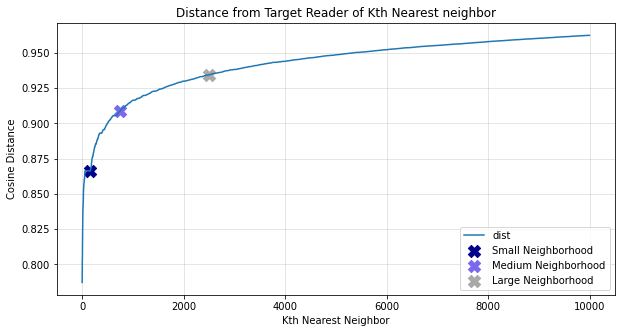

In [256]:
# Take a very large neighborhood to see how reader similarity decreases with K
n, t, dists = find_neighbors(10000, target, df_reviews, book_index, df_books)

# Plot distance by kth closest neighbor
fig, ax = plt.subplots(figsize=(10,5))
pd.DataFrame(dists.T).rename(columns={0:"dist"})[1:10000].plot(ax=ax)
plt.title("Distance from Target Reader of Kth Nearest neighbor")
plt.xlabel("Kth Nearest Neighbor")
plt.ylabel("Cosine Distance")
ax.yaxis.grid(True, alpha=0.4) # Create y gridlines
ax.xaxis.grid(True, alpha=0.4) # Create x gridlines
plt.scatter(SM, dists[0,SM], color="darkblue", marker="X", label="Small Neighborhood", s=150)
plt.scatter(MD, dists[0,MD], color="mediumslateblue", marker="X", label="Medium Neighborhood", s=150)
plt.scatter(LG, dists[0,LG], color="darkgray", marker="X", label="Large Neighborhood", s=150)
plt.legend()
plt.show()

In [216]:
# Perform KNN on user rating matrix
sm_neighborhood_ratings, target_user_ratings, d = find_neighbors(
                                                        SM, target, df_reviews, book_index, df_books)

# Find med number of similar users than before to get broader pool of potentially relevant books
med_neighborhood_ratings, target_user_ratings, d = find_neighbors(
                                                    MD, target, df_reviews, book_index, df_books)

# Find larger number of similar users 
lg_neighborhood_ratings, target_user_ratings, d = find_neighbors(
                                                        LG, target, df_reviews, book_index, df_books)

print(f"Small neighborhood contains {sm_neighborhood_ratings['book_index'].nunique():,} books")
print(f"Medium neighborhood contains {med_neighborhood_ratings['book_index'].nunique():,} books")
print(f"Large neighborhood contains {lg_neighborhood_ratings['book_index'].nunique():,} books")

Small neighborhood contains 521 books
Medium neighborhood contains 4,242 books
Large neighborhood contains 15,324 books


<a id='Part1.2'></a>
### 1.2 - Generate Recommendations

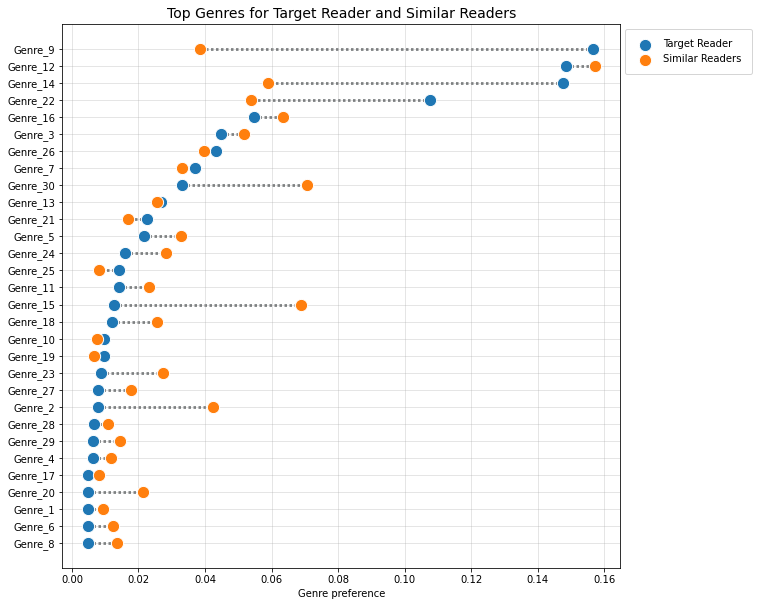

In [217]:
# Show top genres
plot_top_genres(sm_neighborhood_ratings, target_user_ratings)

In [218]:
# View most popular books among neighbors
neighbors_most_popular(sm_neighborhood_ratings, 15, write_to_excel=False)

,title,avg_rating,ratings_count,year,percent_similar_users_read,url
164,Ready Player One,4.31,376328.0,2011.0,14.0%,https://www.goodreads.com/book/show/9969571-re...
306,"The Way of Kings (The Stormlight Archive, #1)",4.64,151473.0,2010.0,10.0%,https://www.goodreads.com/book/show/7235533-th...
58,Dark Matter,4.10,75794.0,2016.0,10.0%,https://www.goodreads.com/book/show/27833670-d...
274,The Name of the Wind (The Kingkiller Chronicle...,4.55,416634.0,2007.0,8.0%,https://www.goodreads.com/book/show/186074.The...
259,"The Hunger Games (The Hunger Games, #1)",4.34,4899965.0,2008.0,8.0%,https://www.goodreads.com/book/show/2767052-th...
17,All the Light We Cannot See,4.31,498685.0,2014.0,8.0%,https://www.goodreads.com/book/show/18143977-a...
147,"Old Man's War (Old Man's War, #1)",4.23,100702.0,2007.0,8.0%,https://www.goodreads.com/book/show/51964.Old_...
269,The Martian,4.39,435440.0,2014.0,6.0%,https://www.goodreads.com/book/show/18007564-t...
321,"We Are Legion (We Are Bob) (Bobiverse, #1)",4.30,17174.0,2016.0,6.0%,https://www.goodreads.com/book/show/32109569-w...
132,"Me Before You (Me Before You, #1)",4.27,609327.0,2012.0,6.0%,https://www.goodreads.com/book/show/15507958-m...


In [219]:
# View highest rated books among similar readers
neighbors_top_rated(sm_neighborhood_ratings, 15, write_to_excel=False)

,title,avg_rating,ratings_count,year,url
306,"The Way of Kings (The Stormlight Archive, #1)",4.64,151473.0,2010.0,https://www.goodreads.com/book/show/7235533-th...
274,The Name of the Wind (The Kingkiller Chronicle...,4.55,416634.0,2007.0,https://www.goodreads.com/book/show/186074.The...
26,Arcanum Unbounded: The Cosmere Collection,4.54,6493.0,2016.0,https://www.goodreads.com/book/show/28595941-a...
39,"Blood Song (Raven's Shadow, #1)",4.46,45244.0,2012.0,https://www.goodreads.com/book/show/13569581-b...
187,"Six of Crows (Six of Crows, #1)",4.46,102183.0,2015.0,https://www.goodreads.com/book/show/23437156-s...
261,The Josephine B Trilogy,4.45,132.0,2006.0,https://www.goodreads.com/book/show/1308176.Th...
186,Shoe Dog: A Memoir by the Creator of NIKE,4.44,27468.0,2016.0,https://www.goodreads.com/book/show/27220736-s...
240,"The Final Empire (Mistborn, #1)",4.43,216149.0,2006.0,https://www.goodreads.com/book/show/68428.The_...
244,The Found and the Lost: The Collected Novellas...,4.43,182.0,2016.0,https://www.goodreads.com/book/show/29868611-t...
118,"Kings of the Wyld (The Band, #1)",4.42,2285.0,2017.0,https://www.goodreads.com/book/show/30841984-k...


In [220]:
# View highest rated books by each of the top genres
show_top_recs_by_genre(
    target=target_user_ratings, 
    others=sm_neighborhood_ratings, 
    how="KNN", 
    whose_genres="target", 
    n_genres=10, 
    min_score=3.9, 
    n_recs=15,
    write_to_excel=False
)

Genre 9: ['war', 'history', 'account', 'family', 'year', 'young', 'world', 'time', 'memoir', 'portrait']


,title,avg_rating,ratings_count,url
17,The Josephine B Trilogy,4.45,132.0,https://www.goodreads.com/book/show/1308176.Th...
15,The Godfather,4.36,259150.0,https://www.goodreads.com/book/show/22034.The_...
1,A Thousand Splendid Suns,4.34,835172.0,https://www.goodreads.com/book/show/128029.A_T...
10,On Writing: A Memoir of the Craft,4.31,135528.0,https://www.goodreads.com/book/show/10569.On_W...
14,The Emperor of All Maladies: A Biography of Ca...,4.29,49534.0,https://www.goodreads.com/book/show/7170627-th...
22,V for Vendetta,4.25,212464.0,https://www.goodreads.com/book/show/5805.V_for...
4,Bury My Heart at Wounded Knee: An Indian Histo...,4.21,41180.0,https://www.goodreads.com/book/show/76401.Bury...
19,The Red Tent,4.16,428809.0,https://www.goodreads.com/book/show/4989.The_R...
8,North and South,4.13,98068.0,https://www.goodreads.com/book/show/156538.Nor...
7,Mortality,4.12,14530.0,https://www.goodreads.com/book/show/13529055-m...


_____

Genre 12: ['alien', 'planet', 'world', 'human', 'space', 'war', 'galaxy', 'race', 'ship', 'humanity']


,title,avg_rating,ratings_count,url
1,A Night Without Stars,4.41,1758.0,https://www.goodreads.com/book/show/28530221-a...
64,The Martian,4.39,435440.0,https://www.goodreads.com/book/show/18007564-t...
72,The Stand,4.34,449730.0,https://www.goodreads.com/book/show/149267.The...
79,"We Are Legion (We Are Bob) (Bobiverse, #1)",4.30,17174.0,https://www.goodreads.com/book/show/32109569-w...
28,Judas Unchained,4.30,21306.0,https://www.goodreads.com/book/show/45244.Juda...
74,"This Book Is Full of Spiders: Seriously, Dude,...",4.26,294.0,https://www.goodreads.com/book/show/17286949-t...
38,"Pandora's Star (Commonwealth Saga, #1)",4.24,1312.0,https://www.goodreads.com/book/show/6136470-pa...
34,"Old Man's War (Old Man's War, #1)",4.23,100702.0,https://www.goodreads.com/book/show/51964.Old_...
77,Understand,4.22,869.0,https://www.goodreads.com/book/show/7234685-un...
53,The Abyss Beyond Dreams,4.21,4944.0,https://www.goodreads.com/book/show/20697413-t...


_____

Genre 14: ['political', 'history', 'world', 'economic', 'government', 'global', 'politics', 'social', 'country', 'financial']


,title,avg_rating,ratings_count,url
15,On Tyranny: Twenty Lessons from the Twentieth ...,4.29,9145.0,https://www.goodreads.com/book/show/33917107-o...
16,Our Revolution: A Future to Believe In,4.29,2430.0,https://www.goodreads.com/book/show/31741420-o...
10,Elon Musk: Inventing the Future,4.24,63849.0,https://www.goodreads.com/book/show/22543496-e...
11,"Elon Musk: Tesla, SpaceX, and the Quest for a ...",4.24,11750.0,https://www.goodreads.com/book/show/22535480-e...
14,Hun Sen’s Cambodia,4.20,105.0,https://www.goodreads.com/book/show/21945075-h...
29,"Titan: The Life of John D. Rockefeller, Sr.",4.19,8970.0,https://www.goodreads.com/book/show/16121.Titan
5,"Blood Meridian, or the Evening Redness in the ...",4.18,72755.0,https://www.goodreads.com/book/show/394535.Blo...
28,The Sleepwalkers: How Europe Went to War in 1914,4.18,3830.0,https://www.goodreads.com/book/show/18669169-t...
8,Daemon (Daemon #1),4.17,9355.0,https://www.goodreads.com/book/show/6665847-da...
2,Amusing Ourselves to Death: Public Discourse i...,4.15,10133.0,https://www.goodreads.com/book/show/74034.Amus...


_____

Genre 22: ['history', 'poem', 'text', 'introduction', 'writing', 'science', 'translation', 'literature', 'essay', 'modern']


,title,avg_rating,ratings_count,url
16,The Authoritarians,4.31,354.0,https://www.goodreads.com/book/show/1971601.Th...
5,Chess Story,4.28,17661.0,https://www.goodreads.com/book/show/59151.Ches...
14,Stories of Your Life and Others,4.27,17769.0,https://www.goodreads.com/book/show/223380.Sto...
21,The Hero With a Thousand Faces,4.24,18378.0,https://www.goodreads.com/book/show/588138.The...
26,Writing Great Fiction: Storytelling Tips and T...,4.24,381.0,https://www.goodreads.com/book/show/24235595-w...
6,Dear Data,4.22,227.0,https://www.goodreads.com/book/show/28465052-d...
10,Meditations,4.20,45727.0,https://www.goodreads.com/book/show/30659.Medi...
8,Guns,4.17,3687.0,https://www.goodreads.com/book/show/17284577-guns
0,A Brief History of Time,4.13,173373.0,https://www.goodreads.com/book/show/3869.A_Bri...
19,"The Fabric of the Cosmos: Space, Time, and the...",4.11,24820.0,https://www.goodreads.com/book/show/22435.The_...


_____

Genre 16: ['guide', 'help', 'health', 'technique', 'way', 'practical', 'advice', 'people', 'business', 'learn']


,title,avg_rating,ratings_count,url
35,Your Deceptive Mind: A Scientific Guide to Cri...,4.30,1005.0,https://www.goodreads.com/book/show/13562148-y...
21,The Dictator's Handbook: Why Bad Behavior is A...,4.27,2497.0,https://www.goodreads.com/book/show/11612989-t...
29,Turn the Ship Around!: A True Story of Turning...,4.26,2684.0,https://www.goodreads.com/book/show/16158601-t...
5,"Creativity, Inc.: Overcoming the Unseen Forces...",4.24,27705.0,https://www.goodreads.com/book/show/18077903-c...
22,The Hard Thing About Hard Things: Building a B...,4.20,20745.0,https://www.goodreads.com/book/show/18176747-t...
7,Deep Work: Rules for Focused Success in a Dist...,4.19,15605.0,https://www.goodreads.com/book/show/25744928-d...
10,Influence: The Psychology of Persuasion,4.18,47682.0,https://www.goodreads.com/book/show/28815.Infl...
34,Your Best Brain: The Science of Brain Improvement,4.18,261.0,https://www.goodreads.com/book/show/23626805-y...
33,Work Rules!: Insights from Inside Google That ...,4.16,4902.0,https://www.goodreads.com/book/show/22875447-w...
11,Leaders Eat Last,4.12,9080.0,https://www.goodreads.com/book/show/16144853-l...


_____

Genre 3: ['spiritual', 'faith', 'people', 'experience', 'church', 'way', 'world', 'question', 'personal', 'wisdom']


,title,avg_rating,ratings_count,url
12,Man's Search for Meaning,4.33,179906.0,https://www.goodreads.com/book/show/4069.Man_s...
6,Falling Upward: A Spirituality for the Two Hal...,4.24,4884.0,https://www.goodreads.com/book/show/9963483-fa...
25,The Prophet,4.23,145579.0,https://www.goodreads.com/book/show/2547.The_P...
3,Becoming Wise: An Inquiry into the Mystery and...,4.22,1683.0,https://www.goodreads.com/book/show/25894085-b...
5,"Desiring the Kingdom: Worship, Worldview, and ...",4.22,1659.0,https://www.goodreads.com/book/show/5944774-de...
26,The Screwtape Letters,4.21,116487.0,https://www.goodreads.com/book/show/11149.The_...
18,TED Talks: The Official TED Guide to Public Sp...,4.20,2368.0,https://www.goodreads.com/book/show/25897871-t...
8,Have a Little Faith: a True Story,4.16,60867.0,https://www.goodreads.com/book/show/1255781.Ha...
11,Imagining the Kingdom: How Worship Works,4.15,390.0,https://www.goodreads.com/book/show/15863575-i...
22,The Essential Dalai Lama: His Important Teachings,4.12,315.0,https://www.goodreads.com/book/show/237924.The...


_____

Genre 26: ['war', 'king', 'throne', 'family', 'young', 'world', 'royal', 'court', 'power', 'kingdom']


,title,avg_rating,ratings_count,url
6,Gates of Fire: An Epic Novel of the Battle of ...,4.40,18299.0,https://www.goodreads.com/book/show/1305.Gates...
2,"Dawn of Wonder (The Wakening, #1)",4.35,13351.0,https://www.goodreads.com/book/show/25451852-d...
14,The Emperor's Soul,4.33,35260.0,https://www.goodreads.com/book/show/13578175-t...
16,"The Lies of Locke Lamora (Gentleman Bastard, #1)",4.30,123373.0,https://www.goodreads.com/book/show/127455.The...
9,"Outlander (Outlander, #1)",4.21,531055.0,https://www.goodreads.com/book/show/10964.Outl...
3,Dune (Dune Chronicles #1),4.20,494553.0,https://www.goodreads.com/book/show/234225.Dune
5,"Elantris (Elantris, #1)",4.17,100115.0,https://www.goodreads.com/book/show/68427.Elan...
4,Elantris,4.17,1420.0,https://www.goodreads.com/book/show/10803709-e...
1,"Assassin's Apprentice (Farseer Trilogy, #1)",4.14,133239.0,https://www.goodreads.com/book/show/45107.Assa...
7,Jane Eyre,4.10,1207986.0,https://www.goodreads.com/book/show/10210.Jane...


_____

Genre 7: ['film', 'music', 'funny', 'movie', 'hilarious', 'year', 'memoir', 'world', 'time', 'star']


,title,avg_rating,ratings_count,url
8,Shoe Dog: A Memoir by the Creator of NIKE,4.44,27468.0,https://www.goodreads.com/book/show/27220736-s...
9,"Surely You're Joking, Mr. Feynman!: Adventures...",4.29,95353.0,https://www.goodreads.com/book/show/5544.Surel...
2,Masters of Doom: How Two Guys Created an Empir...,4.23,7357.0,https://www.goodreads.com/book/show/222146.Mas...
4,No One Writes Back,4.19,154.0,https://www.goodreads.com/book/show/17591572-n...
6,"Searching for Sunday: Loving, Leaving, and Fin...",4.09,5560.0,https://www.goodreads.com/book/show/22574709-s...
13,The Rest Is Noise: Listening to the Twentieth ...,4.08,9607.0,https://www.goodreads.com/book/show/392563.The...
0,Grace's Guide: The Art of Pretending to Be a G...,4.04,6917.0,https://www.goodreads.com/book/show/22168240-g...
5,On the Move: A Life,4.03,9163.0,https://www.goodreads.com/book/show/24972194-o...
7,Sh*t My Dad Says,3.98,104317.0,https://www.goodreads.com/book/show/7821447-sh...
11,"The Eyre Affair (Thursday Next, #1)",3.91,86867.0,https://www.goodreads.com/book/show/27003.The_...


_____

Genre 30: ['world', 'young', 'family', 'place', 'fiction', 'time', 'year', 'journey', 'house', 'dark']


,title,avg_rating,ratings_count,url
2,A Gentleman in Moscow,4.37,44419.0,https://www.goodreads.com/book/show/29430012-a...
10,Jackalope Wives,4.35,460.0,https://www.goodreads.com/book/show/20527580-j...
3,All the Light We Cannot See,4.31,498685.0,https://www.goodreads.com/book/show/18143977-a...
28,"The Pillars of the Earth (Kingsbridge, #1)",4.29,471990.0,https://www.goodreads.com/book/show/5043.The_P...
33,The Waste Lands,4.24,121199.0,https://www.goodreads.com/book/show/34084.The_...
23,The Drawing of the Three,4.23,143971.0,https://www.goodreads.com/book/show/5094.The_D...
14,Neverwhere,4.18,275822.0,https://www.goodreads.com/book/show/14497.Neve...
19,The Amazing Adventures of Kavalier & Clay,4.17,149976.0,https://www.goodreads.com/book/show/3985.The_A...
9,Imajica,4.16,15828.0,https://www.goodreads.com/book/show/567704.Ima...
34,The Wind Through the Keyhole,4.15,37166.0,https://www.goodreads.com/book/show/12341557-t...


_____

Genre 13: ['collection', 'short', 'comic', 'available', 'novella', 'feature', 'bestselling', 'includes', 'anthology', 'fiction']


,title,avg_rating,ratings_count,url
1,Arcanum Unbounded: The Cosmere Collection,4.54,6493.0,https://www.goodreads.com/book/show/28595941-a...
8,The Found and the Lost: The Collected Novellas...,4.43,182.0,https://www.goodreads.com/book/show/29868611-t...
2,Beyond the Aquila Rift: The Best of Alastair R...,4.30,163.0,https://www.goodreads.com/book/show/28931839-b...
7,The Circular Ruins,4.30,409.0,https://www.goodreads.com/book/show/28110198-t...
0,2016 on Goodreads,4.25,1167.0,https://www.goodreads.com/book/show/33232571-2...
9,"The Hedge Knight (The Tales of Dunk and Egg, #1)",4.23,14640.0,https://www.goodreads.com/book/show/11970747-t...
6,Sixth of the Dusk,4.21,8122.0,https://www.goodreads.com/book/show/23397921-s...
10,The Hitchhiker's Guide to the Galaxy (Hitchhik...,4.20,940154.0,https://www.goodreads.com/book/show/11.The_Hit...
11,The Hitchhiker's Guide to the Galaxy (Hitchhik...,4.20,35184.0,https://www.goodreads.com/book/show/386162.The...
5,Other People,4.19,373.0,https://www.goodreads.com/book/show/16176131-o...


_____



## Part 2 - Collaborative Filtering Based on Predicted Ratings with Matrix Factorization

#### 2.1 - Factorize User-Rating Matrix with SVD

In sections [2.1](#21---factorize-user-rating-matrix-with-svd) and [2.2](#22---generate-recommendations-by-predicting-ratings) we use singular value decomposition (SVD) to factorize the user-rating matrix generated from the 1500 most similar readers to the target reader, as determined by KNN. SVD decomposes our $m * n$ user-rating matrix $R$ into 3 smaller matrices: $$\mathbf{R} = \mathbf{U} \mathbf{\Sigma} \mathbf{V}^\top$$ where $\mathbf{U}$, the left singular vectors, represents an $m * k$ embedding space of user features and $\mathbf{V}^\top$, the right singular vectors, represents a $k * n$ embedding of book features. Estimated ratings come from multiplying the decomposed matrices together to approximate $R$. 

The advantage of SVD is its simplicity and computational efficiency. The disadvantage is that it requires unseen ratings to be encoded as 0 and therefore all predicted ratings on unread books are near zero rather than more realistic values. 

In [221]:
# Choose neighborhood size for SVD
svd_neighborhood_ratings = lg_neighborhood_ratings

In [222]:
# Get unique users and books to slice df_reviews
svd_neighbor_index = svd_neighborhood_ratings["uid"].unique()
svd_neighbor_index = np.append(svd_neighbor_index, target)
svd_neighbor_book_index = svd_neighborhood_ratings["book_index"].unique()
svd_neighbor_book_index = np.append(svd_neighbor_book_index, target_user_ratings["book_index"].unique())

print(f"Neighborhood contains {svd_neighbor_book_index.shape[0]:,} books")

# Slice df_reviews to make User Ratings Matrix
R = df_reviews[:, svd_neighbor_book_index]
R = R[svd_neighbor_index, :]

Neighborhood contains 15,433 books


In [223]:
# Decompose user ratings matrix R with SVD
U, sigma, Vt = svds(R, k=40)
sigma = np.diag(sigma)

# Convert to sparse matrix
U = sparse.csr_matrix(U)
sigma = sparse.csr_matrix(sigma)
Vt = sparse.csr_matrix(Vt)

#### 2.2 - Generate Recommendations by Predicting Ratings

In [224]:
# Get predictions
all_user_predicted_ratings = U.dot(sigma) @ Vt
df_preds = pd.DataFrame(
                all_user_predicted_ratings.toarray(), columns=svd_neighbor_book_index, index=svd_neighbor_index
                ).reset_index()

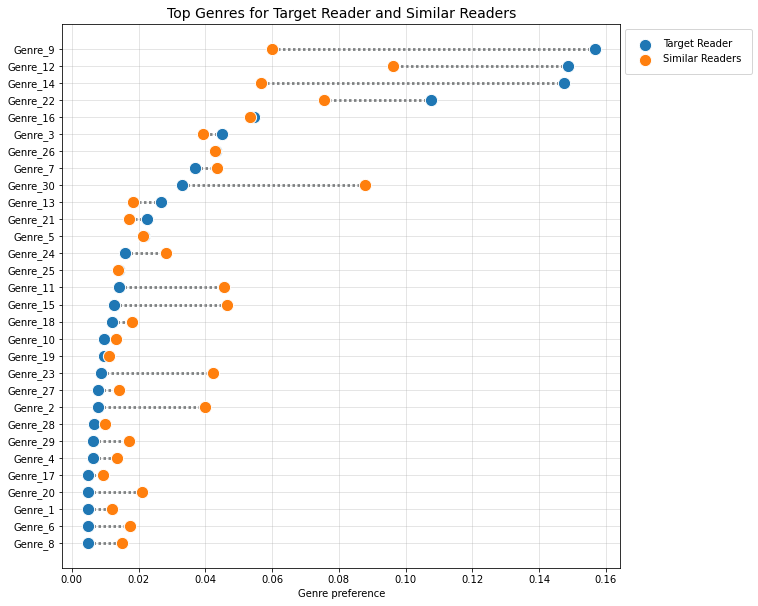

In [225]:
# Show top genres
plot_top_genres(svd_neighborhood_ratings, target_user_ratings)

In [226]:
# Get top recs from predictions
def get_recs(preds, target_reader, book_ind, books, write_to_excel=False):
    
    target_pred_books = preds[preds["index"] == target_reader].columns[1:]
    target_pred_ratings = preds[preds["index"] == target_reader].values[0][1:]

    # Put into df with relevant info from df_books
    top_preds = pd.DataFrame({"book_index":target_pred_books, "predicted_rating":target_pred_ratings})\
                    .sort_values(by="predicted_rating", ascending=False)\
                    .merge(book_ind.reset_index(), left_on="book_index", right_on="index")\
                    .merge(
                        books[["book_id", "title", "avg_rating", "ratings_count", "year", "main_genre","url"]],
                        on="book_id"
                    )\
                    .drop(columns=["index"])

    # Filter out already read books
    top_preds = top_preds[~top_preds["book_index"].isin(target_user_ratings["book_index"].unique())]
    top_preds.drop(["book_index"], axis=1, inplace=True)

    if write_to_excel == True:
        # Write to excel
        path = wd + "/data/book_recs.xlsx"
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                top_preds.query("avg_rating > 3.9").drop(columns=["predicted_rating", "main_genre"])\
                    .head(50).to_excel(writer, sheet_name="Top by Predicted Score", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                top_preds.query("avg_rating > 3.9").drop(columns=["predicted_rating", "main_genre"])\
                    .head(50).to_excel(writer, sheet_name="Top by Predicted Score", index=False)
        writer.close

    return top_preds

In [227]:
# View books with highest target user predicted score
top_preds = get_recs(df_preds, target, book_index, df_books, write_to_excel=False)
top_preds[["title","avg_rating","predicted_rating","ratings_count","year","url"]]\
                .query("avg_rating > 3.9").head(20)

,title,avg_rating,predicted_rating,ratings_count,year,url
32,"The Way of Kings (The Stormlight Archive, #1)",4.64,0.044685,151473.0,2010.0,https://www.goodreads.com/book/show/7235533-th...
33,11/22/63,4.29,0.034540,265669.0,2011.0,https://www.goodreads.com/book/show/10644930-1...
34,"Binti (Binti, #1)",4.02,0.030665,7945.0,2015.0,https://www.goodreads.com/book/show/25667918-b...
36,"Ancillary Justice (Imperial Radch, #1)",3.97,0.027526,40736.0,2013.0,https://www.goodreads.com/book/show/17333324-a...
37,"Old Man's War (Old Man's War, #1)",4.23,0.027322,100702.0,2007.0,https://www.goodreads.com/book/show/51964.Old_...
39,The Hitchhiker's Guide to the Galaxy (Hitchhik...,4.20,0.025675,940154.0,1995.0,https://www.goodreads.com/book/show/11.The_Hit...
40,Seveneves,3.98,0.025031,47286.0,2015.0,https://www.goodreads.com/book/show/22816087-s...
42,How to Win Friends and Influence People,4.14,0.024643,296690.0,1998.0,https://www.goodreads.com/book/show/4865.How_t...
43,The Night Circus,4.03,0.024617,441272.0,2011.0,https://www.goodreads.com/book/show/9361589-th...
44,Dark Matter,4.10,0.024462,75794.0,2016.0,https://www.goodreads.com/book/show/27833670-d...


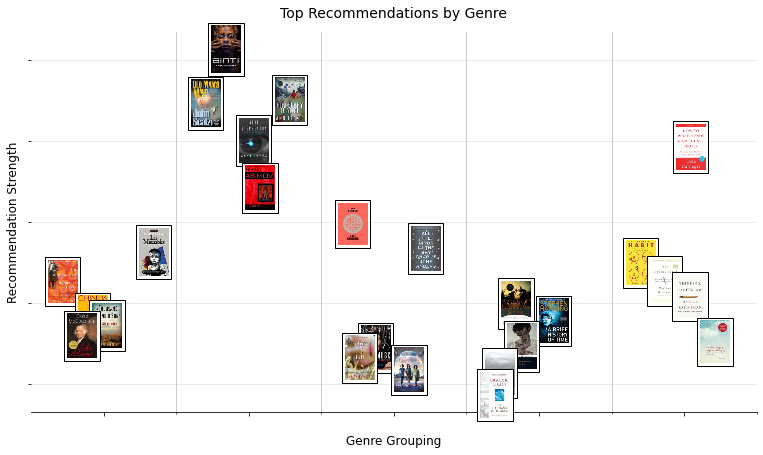

In [228]:
# Display top preds
display_top_books(top_preds, df_books, target_user_ratings)

In [229]:
# View most popular books among neighbors
popular_recs = neighbors_most_popular(svd_neighborhood_ratings, n=50, write_to_excel=False)
popular_recs.head(15)

,title,avg_rating,ratings_count,year,percent_similar_users_read,url
5652,The Martian,4.39,435440.0,2014.0,9.2%,https://www.goodreads.com/book/show/18007564-t...
3692,Ready Player One,4.31,376328.0,2011.0,7.8%,https://www.goodreads.com/book/show/9969571-re...
5393,"The Hunger Games (The Hunger Games, #1)",4.34,4899965.0,2008.0,5.4%,https://www.goodreads.com/book/show/2767052-th...
5742,The Name of the Wind (The Kingkiller Chronicle...,4.55,416634.0,2007.0,5.4%,https://www.goodreads.com/book/show/186074.The...
5103,The Fault in Our Stars,4.26,2429317.0,2012.0,5.1%,https://www.goodreads.com/book/show/11870085-t...
851,Brave New World,3.97,1043619.0,1998.0,3.8%,https://www.goodreads.com/book/show/5129.Brave...
5320,The Handmaid's Tale,4.07,648783.0,1998.0,3.6%,https://www.goodreads.com/book/show/38447.The_...
2747,"Leviathan Wakes (The Expanse, #1)",4.20,72492.0,2011.0,3.4%,https://www.goodreads.com/book/show/8855321-le...
448,"Ancillary Justice (Imperial Radch, #1)",3.97,40736.0,2013.0,3.3%,https://www.goodreads.com/book/show/17333324-a...
6489,"The Way of Kings (The Stormlight Archive, #1)",4.64,151473.0,2010.0,3.2%,https://www.goodreads.com/book/show/7235533-th...


In [230]:
# Highest rated books among similar readers
top_rated = neighbors_top_rated(svd_neighborhood_ratings, n=50, write_to_excel=False)
top_rated.head(15)

,title,avg_rating,ratings_count,year,url
3476,Patrick O'Brian's Aubrey/Maturin Series,4.83,420.0,2010.0,https://www.goodreads.com/book/show/8432716-pa...
6491,"The Way of Kings, Part 2 (The Stormlight Archi...",4.78,7803.0,2011.0,https://www.goodreads.com/book/show/11221285-t...
1462,ESV Study Bible,4.76,9036.0,2008.0,https://www.goodreads.com/book/show/5031805-es...
2937,Mark of the Lion Trilogy,4.76,9189.0,1998.0,https://www.goodreads.com/book/show/95602.Mark...
1344,Digger: The Complete Omnibus,4.72,392.0,2013.0,https://www.goodreads.com/book/show/19276094-d...
3854,Saga: Book One,4.70,4201.0,2014.0,https://www.goodreads.com/book/show/22078240-saga
1814,Free Verse,4.69,114.0,1991.0,https://www.goodreads.com/book/show/365331.Fre...
3855,Saga: Book Two,4.68,866.0,2017.0,https://www.goodreads.com/book/show/32926680-saga
4014,Sherlock Holmes: The Definitive Collection,4.68,240.0,2017.0,https://www.goodreads.com/book/show/34429916-s...
6490,"The Way of Kings, Part 1 (The Stormlight Archi...",4.67,10191.0,2011.0,https://www.goodreads.com/book/show/9329354-th...


In [231]:
# Highest rated books by each of the top genres
show_top_recs_by_genre(
    target_user_ratings, 
    svd_neighborhood_ratings, 
    preds=top_preds, 
    how="MF", 
    whose_genres="target", 
    n_genres=10, 
    min_score=4, 
    n_recs=20,
    write_to_excel=False
)

Genre 9: ['war', 'history', 'account', 'family', 'year', 'young', 'world', 'time', 'memoir', 'portrait']


,title,avg_rating,ratings_count,url
67,Les Misérables,4.14,519758.0,https://www.goodreads.com/book/show/24280.Les_...
81,The Immortal Life of Henrietta Lacks,4.04,390601.0,https://www.goodreads.com/book/show/6493208-th...
113,A Thousand Splendid Suns,4.34,835172.0,https://www.goodreads.com/book/show/128029.A_T...
119,John Adams,4.05,223171.0,https://www.goodreads.com/book/show/2203.John_...
120,The Boys in the Boat: Nine Americans and Their...,4.33,118259.0,https://www.goodreads.com/book/show/16158542-t...
137,Americanah,4.26,118938.0,https://www.goodreads.com/book/show/15796700-a...
145,"Unbroken: A World War II Story of Survival, Re...",4.39,504961.0,https://www.goodreads.com/book/show/8664353-un...
146,On Writing: A Memoir of the Craft,4.31,135528.0,https://www.goodreads.com/book/show/10569.On_W...
151,The Underground Railroad,4.03,86839.0,https://www.goodreads.com/book/show/30555488-t...
156,The Picture of Dorian Gray,4.06,607145.0,https://www.goodreads.com/book/show/5297.The_P...


_____

Genre 12: ['alien', 'planet', 'world', 'human', 'space', 'war', 'galaxy', 'race', 'ship', 'humanity']


,title,avg_rating,ratings_count,url
34,"Binti (Binti, #1)",4.02,7945.0,https://www.goodreads.com/book/show/25667918-b...
37,"Old Man's War (Old Man's War, #1)",4.23,100702.0,https://www.goodreads.com/book/show/51964.Old_...
50,"I, Robot (Robot #0.1)",4.17,201196.0,https://www.goodreads.com/book/show/41804.I_Robot
64,"Leviathan Wakes (The Expanse, #1)",4.20,72492.0,https://www.goodreads.com/book/show/8855321-le...
65,Childhood's End,4.09,89107.0,https://www.goodreads.com/book/show/414999.Chi...
77,"The Long Way to a Small, Angry Planet (Wayfare...",4.18,15139.0,https://www.goodreads.com/book/show/22733729-t...
87,Do Androids Dream of Electric Sheep?,4.08,229370.0,https://www.goodreads.com/book/show/7082.Do_An...
101,Anathem,4.18,45672.0,https://www.goodreads.com/book/show/2845024-an...
107,"Rendezvous with Rama (Rama, #1)",4.06,94581.0,https://www.goodreads.com/book/show/112537.Ren...
121,"The Forever War (The Forever War, #1)",4.15,89663.0,https://www.goodreads.com/book/show/21611.The_...


_____

Genre 14: ['political', 'history', 'world', 'economic', 'government', 'global', 'politics', 'social', 'country', 'financial']


,title,avg_rating,ratings_count,url
130,Elon Musk: Inventing the Future,4.24,63849.0,https://www.goodreads.com/book/show/22543496-e...
275,"Elon Musk: Tesla, SpaceX, and the Quest for a ...",4.24,11750.0,https://www.goodreads.com/book/show/22535480-e...
316,"Daemon (Daemon, #1)",4.17,18162.0,https://www.goodreads.com/book/show/4699575-da...
427,"Blood Meridian, or the Evening Redness in the ...",4.18,72755.0,https://www.goodreads.com/book/show/394535.Blo...
447,Fuzzy Nation,4.10,17539.0,https://www.goodreads.com/book/show/9647532-fu...
473,Seabiscuit: An American Legend,4.20,113228.0,https://www.goodreads.com/book/show/110737.Sea...
555,The Battle For Justice In Palestine: The Case ...,4.25,182.0,https://www.goodreads.com/book/show/17675081-t...
579,The Caped Crusade: Batman and the Rise of Nerd...,4.15,1252.0,https://www.goodreads.com/book/show/27276413-t...
586,The Silk Roads: A New History of the World,4.25,3022.0,https://www.goodreads.com/book/show/25812847-t...
604,Cultures and Organizations: Software of the Mind,4.08,443.0,https://www.goodreads.com/book/show/466760.Cul...


_____

Genre 22: ['history', 'poem', 'text', 'introduction', 'writing', 'science', 'translation', 'literature', 'essay', 'modern']


,title,avg_rating,ratings_count,url
109,A Brief History of Time,4.13,173373.0,https://www.goodreads.com/book/show/3869.A_Bri...
202,The Left Hand of Darkness,4.05,63749.0,https://www.goodreads.com/book/show/18423.The_...
216,Stories of Your Life and Others,4.27,17769.0,https://www.goodreads.com/book/show/223380.Sto...
236,"The Diamond Age: or, A Young Lady's Illustrate...",4.19,62866.0,https://www.goodreads.com/book/show/827.The_Di...
268,Pale Blue Dot: A Vision of the Human Future in...,4.32,20464.0,https://www.goodreads.com/book/show/61663.Pale...
278,Watchmen,4.35,406669.0,https://www.goodreads.com/book/show/472331.Wat...
298,The Sixth Extinction: An Unnatural History,4.10,22329.0,https://www.goodreads.com/book/show/17910054-t...
307,Black Holes and Baby Universes,4.09,9704.0,https://www.goodreads.com/book/show/53200.Blac...
350,Pride and Prejudice,4.25,2078406.0,https://www.goodreads.com/book/show/1885.Pride...
385,The Master and Margarita,4.32,136321.0,https://www.goodreads.com/book/show/117833.The...


_____

Genre 16: ['guide', 'help', 'health', 'technique', 'way', 'practical', 'advice', 'people', 'business', 'learn']


,title,avg_rating,ratings_count,url
42,How to Win Friends and Influence People,4.14,296690.0,https://www.goodreads.com/book/show/4865.How_t...
71,The Power of Habit: Why We Do What We Do in Li...,4.03,160604.0,https://www.goodreads.com/book/show/12609433-t...
89,"Thinking, Fast and Slow",4.09,144569.0,https://www.goodreads.com/book/show/11468377-t...
115,Influence: The Psychology of Persuasion,4.18,47682.0,https://www.goodreads.com/book/show/28815.Infl...
194,Deep Work: Rules for Focused Success in a Dist...,4.19,15605.0,https://www.goodreads.com/book/show/25744928-d...
210,The End of Eternity,4.21,27229.0,https://www.goodreads.com/book/show/509784.The...
220,"Creativity, Inc.: Overcoming the Unseen Forces...",4.24,27705.0,https://www.goodreads.com/book/show/18077903-c...
230,Being Mortal: Medicine and What Matters in the...,4.41,60064.0,https://www.goodreads.com/book/show/20696006-b...
271,Good to Great: Why Some Companies Make the Lea...,4.05,86729.0,https://www.goodreads.com/book/show/76865.Good...
282,Hunger: A Memoir of (My) Body,4.31,15334.0,https://www.goodreads.com/book/show/22813605-h...


_____

Genre 3: ['spiritual', 'faith', 'people', 'experience', 'church', 'way', 'world', 'question', 'personal', 'wisdom']


,title,avg_rating,ratings_count,url
46,Quiet: The Power of Introverts in a World That...,4.04,208008.0,https://www.goodreads.com/book/show/8520610-quiet
83,Man's Search for Meaning,4.33,179906.0,https://www.goodreads.com/book/show/4069.Man_s...
218,The Subtle Art of Not Giving a F*ck: A Counter...,4.02,60032.0,https://www.goodreads.com/book/show/28257707-t...
238,The Last Lecture,4.25,245804.0,https://www.goodreads.com/book/show/2318271.Th...
241,The Prophet,4.23,145579.0,https://www.goodreads.com/book/show/2547.The_P...
260,Einstein: His Life and Universe,4.08,73712.0,https://www.goodreads.com/book/show/10884.Eins...
348,The 7 Habits of Highly Effective People: Power...,4.05,330726.0,https://www.goodreads.com/book/show/36072.The_...
469,The Power of Now: A Guide to Spiritual Enlight...,4.11,109355.0,https://www.goodreads.com/book/show/6708.The_P...
489,We Should All Be Feminists,4.47,51354.0,https://www.goodreads.com/book/show/22738563-w...
496,The Righteous Mind: Why Good People are Divide...,4.16,13500.0,https://www.goodreads.com/book/show/11324722-t...


_____

Genre 26: ['war', 'king', 'throne', 'family', 'young', 'world', 'royal', 'court', 'power', 'kingdom']


,title,avg_rating,ratings_count,url
82,"Outlander (Outlander, #1)",4.21,531055.0,https://www.goodreads.com/book/show/10964.Outl...
85,Dune (Dune Chronicles #1),4.20,494553.0,https://www.goodreads.com/book/show/234225.Dune
139,"The Lies of Locke Lamora (Gentleman Bastard, #1)",4.30,123373.0,https://www.goodreads.com/book/show/127455.The...
140,The Traitor Baru Cormorant (Baru Cormorant #1),4.04,5025.0,https://www.goodreads.com/book/show/23444482-t...
189,The Goblin Emperor,4.05,12081.0,https://www.goodreads.com/book/show/17910048-t...
197,The Poisonwood Bible,4.03,552392.0,https://www.goodreads.com/book/show/7244.The_P...
234,"Elantris (Elantris, #1)",4.17,100115.0,https://www.goodreads.com/book/show/68427.Elan...
330,"City of Stairs (The Divine Cities, #1)",4.12,12578.0,https://www.goodreads.com/book/show/20174424-c...
331,The 48 Laws of Power,4.18,39588.0,https://www.goodreads.com/book/show/1303.The_4...
341,Tigana,4.12,31488.0,https://www.goodreads.com/book/show/104089.Tigana


_____

Genre 7: ['film', 'music', 'funny', 'movie', 'hilarious', 'year', 'memoir', 'world', 'time', 'star']


,title,avg_rating,ratings_count,url
149,Shoe Dog: A Memoir by the Creator of NIKE,4.44,27468.0,https://www.goodreads.com/book/show/27220736-s...
198,Breakfast of Champions,4.08,180318.0,https://www.goodreads.com/book/show/4980.Break...
206,"Surely You're Joking, Mr. Feynman!: Adventures...",4.29,95353.0,https://www.goodreads.com/book/show/5544.Surel...
363,You're Never Weird on the Internet,4.14,29419.0,https://www.goodreads.com/book/show/23705512-y...
368,Shrill: Notes from a Loud Woman,4.22,17212.0,https://www.goodreads.com/book/show/29340182-s...
494,Bluebeard,4.02,27417.0,https://www.goodreads.com/book/show/9601.Blueb...
540,That is All,4.03,1745.0,https://www.goodreads.com/book/show/11065215-t...
599,I Can't Make This Up: Life Lessons,4.06,7385.0,https://www.goodreads.com/book/show/33347428-i...
706,Hamilton: The Revolution,4.47,26640.0,https://www.goodreads.com/book/show/26200563-h...
717,Masters of Doom: How Two Guys Created an Empir...,4.23,7357.0,https://www.goodreads.com/book/show/222146.Mas...


_____

Genre 30: ['world', 'young', 'family', 'place', 'fiction', 'time', 'year', 'journey', 'house', 'dark']


,title,avg_rating,ratings_count,url
43,The Night Circus,4.03,441272.0,https://www.goodreads.com/book/show/9361589-th...
44,Dark Matter,4.10,75794.0,https://www.goodreads.com/book/show/27833670-d...
48,Station Eleven,4.02,166920.0,https://www.goodreads.com/book/show/20170404-s...
108,Cloud Atlas,4.01,155020.0,https://www.goodreads.com/book/show/49628.Clou...
116,Blindness,4.08,100752.0,https://www.goodreads.com/book/show/2526.Blind...
154,One Hundred Years of Solitude,4.04,497852.0,https://www.goodreads.com/book/show/320.One_Hu...
169,Neverwhere,4.18,275822.0,https://www.goodreads.com/book/show/14497.Neve...
217,All the Light We Cannot See,4.31,498685.0,https://www.goodreads.com/book/show/18143977-a...
227,The Drawing of the Three,4.23,143971.0,https://www.goodreads.com/book/show/5094.The_D...
272,The Waste Lands,4.24,121199.0,https://www.goodreads.com/book/show/34084.The_...


_____

Genre 13: ['collection', 'short', 'comic', 'available', 'novella', 'feature', 'bestselling', 'includes', 'anthology', 'fiction']


,title,avg_rating,ratings_count,url
39,The Hitchhiker's Guide to the Galaxy (Hitchhik...,4.20,940154.0,https://www.goodreads.com/book/show/11.The_Hit...
411,Saga: Book One,4.70,4201.0,https://www.goodreads.com/book/show/22078240-saga
424,Stephen Hawking's a Brief History of Time: A R...,4.10,315.0,https://www.goodreads.com/book/show/17352.Step...
477,Bloodline,4.06,6476.0,https://www.goodreads.com/book/show/27209239-b...
642,The Paper Menagerie and Other Stories,4.37,4081.0,https://www.goodreads.com/book/show/24885533-t...
839,Other People,4.19,373.0,https://www.goodreads.com/book/show/16176131-o...
884,Arcanum Unbounded: The Cosmere Collection,4.54,6493.0,https://www.goodreads.com/book/show/28595941-a...
901,The Paper Menagerie,4.37,2476.0,https://www.goodreads.com/book/show/13501210-t...
1110,The Hitchhiker's Guide to the Galaxy (Hitchhik...,4.20,35184.0,https://www.goodreads.com/book/show/386162.The...
1172,At the Mountains of Madness and Other Tales of...,4.25,19861.0,https://www.goodreads.com/book/show/32769.At_t...


_____



### 2.3 Matrix Factorization with Gradient Descent

In section [2.3](#23-matrix-factorization-with-gradient-descent) we use gradient descent to train user and book embedding matrices $P$ and $Q$. We minimize the loss function: $$L = (r_{ij} - \sum_{k=1}^{K} p_{ik}q_{kj})^2 + \frac{\beta}{2}\sum_{k=1}^{K}(||P||^2 + ||Q||^2)$$ for all $r_{ij} > 0$ using alternating least squares. After training, we reconstruct $R$ matrix by multiplyting $P * Q$. See [here](http://www.quuxlabs.com/blog/2010/09/matrix-factorization-a-simple-tutorial-and-implementation-in-python/) for a helpful description of the math.

The advantage of gradient descent is that we can train the model on nonzero ratings (i.e. only for books users have actually rated) and apply it to unread books, which yields realistic rating predictions. The downside is that it is computationally very expensive. Larger user-raing $R$ matrices have exponentially more values than smaller ones, so there is a limit to how many nearest neighbors we can use to generate the full set of book ratings to consider. 

In [232]:
# Choose neighborhood size for GD
gd_neighborhoodhood_ratings = med_neighborhood_ratings

In [233]:
# Get unique users and books to slice df_reviews
gd_neighborhood_index = gd_neighborhoodhood_ratings["uid"].unique()
gd_neighborhood_index = np.append(gd_neighborhood_index, target)
gd_neighborhood_book_index = gd_neighborhoodhood_ratings["book_index"].unique()
gd_neighborhood_book_index = np.append(gd_neighborhood_book_index, target_user_ratings["book_index"].unique())
print(f"Neighborhood contains {gd_neighborhood_book_index.shape[0]:,} books")

# Slice df_reviews to make User Ratings Matrix
R = df_reviews[:, gd_neighborhood_book_index]
R = R[gd_neighborhood_index, :]
R = R.toarray()

Neighborhood contains 4,351 books


In [234]:
# Function to train embedding matrices using alternating least squares (ALS) and make predictions 
def matrix_factorization(R, k_components=15, steps=200, lr=0.0002, beta=0.01, decay=True, verbose=0):
    """
    Uses gradient descent to train matrix factorization algorithm

    Args:
        R: Utility matrix of user item ratings         
        k: Number of latent features
        steps: Number of epochs to run training
        lr: Learning rate
        beta: Regularization strength
        verbose: Prints updates if 1

    Returns:
        Predictions, User Embeddings, Item Embdeddings
    """

    # Initialize random values for user (P) and book (Q) embedding matrices    
    P = np.random.rand(R.shape[0],k_components)
    Q = np.random.rand(R.shape[1],k_components).T

    # Get nonzero ratings to perform operations on
    r_0 = np.where(R > 0) # Find indices where rating > 0
    i = r_0[0] # Get row indices where rating > 0
    j = r_0[1] # Get column indices where rating > 0 
    nonzero_ratings = R[i,j]

    # For each step calc residual and take step down gradient
    for step in range(steps): 
        resid = nonzero_ratings - (P @ Q)[i,j] # residual is value - r_hat       
        for k in range(k_components): # for each component (latent feature)                
            P[i,k] = P[i,k] + lr * (2 * resid * Q[k,j] - beta * P[i,k]) # Update P by step in gradient                             
            Q[k,j] = Q[k,j] + lr * (2 * resid * P[i,k] - beta * Q[k,j]) # Update Q by step in gradient                    

        # Calculate error every n steps                  
        if (((step + 1) / (steps / 5)) % 1 == 0) | (step == 0):                                  
            error = np.sum(pow(resid, 2)) + (beta/2) * np.linalg.norm(P,2) + np.linalg.norm(Q,2)
            
            # View progress
            if verbose == 1:
                print(f"Step: {step + 1}, Loss: {error:.2f}, lr: {lr:.5f}") 
            
            # Set learning rate to decay until 0.00002
            if decay == True:
                if lr > 0.00002:                                
                    lr = lr / 1.5
    
    # Get predictions
    preds = np.dot(P, Q)

    return preds, P, Q.T

In [235]:
# Train model and get predictions
preds, user_embed, item_embed = matrix_factorization(
                                    R, 
                                    k_components=15, 
                                    lr=0.002, 
                                    beta=1.5,
                                    decay=True, 
                                    steps=200, 
                                    verbose=1
                                )
df_preds_GD = pd.DataFrame(preds, columns=gd_neighborhood_book_index, index=gd_neighborhood_index)\
                .reset_index()

Step: 1, Loss: 133422.94, lr: 0.00200


Step: 40, Loss: 30707.30, lr: 0.00133
Step: 80, Loss: 15250.41, lr: 0.00089
Step: 120, Loss: 10304.61, lr: 0.00059
Step: 160, Loss: 8130.33, lr: 0.00040
Step: 200, Loss: 7005.00, lr: 0.00026


In [236]:
# View top predicted ratings
top_preds_GD = get_recs(df_preds_GD, target, book_index, df_books, write_to_excel=False)
top_preds_GD[["title","avg_rating","predicted_rating","ratings_count","year","url"]]\
                .query("avg_rating > 3.9 and ratings_count > 400").head(20)

,title,avg_rating,predicted_rating,ratings_count,year,url
0,How an Economy Grows and Why It Crashes,4.13,1.863208,2224.0,2010.0,https://www.goodreads.com/book/show/7048818-ho...
2,The Dirt: Confessions of the World's Most Noto...,4.16,1.823040,22907.0,2002.0,https://www.goodreads.com/book/show/25378.The_...
7,Searching for God Knows What,3.92,1.748603,19942.0,2004.0,https://www.goodreads.com/book/show/33333.Sear...
9,"Red Dragon (Hannibal Lecter, #1)",4.02,1.736242,198259.0,2000.0,https://www.goodreads.com/book/show/28877.Red_...
10,Wool,4.24,1.729834,5048.0,2013.0,https://www.goodreads.com/book/show/17164655-wool
11,The Moon is a Harsh Mistress,4.17,1.718033,81655.0,2005.0,https://www.goodreads.com/book/show/16690.The_...
14,"Graceling (Graceling Realm, #1)",4.10,1.675953,287983.0,2008.0,https://www.goodreads.com/book/show/3236307-gr...
15,Dear Martin,4.46,1.674234,1566.0,2017.0,https://www.goodreads.com/book/show/24974996-d...
17,The Autobiography of Malcolm X,4.29,1.659559,130860.0,1965.0,https://www.goodreads.com/book/show/92057.The_...
20,Twelve Years a Slave,4.16,1.630724,41178.0,2013.0,https://www.goodreads.com/book/show/18478222-t...


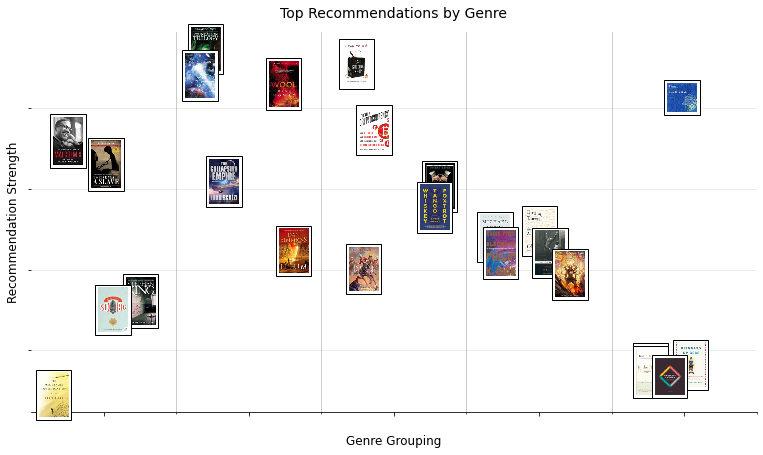

In [237]:
# Display top preds
display_top_books(top_preds_GD, df_books, target_user_ratings)

In [238]:
# Highest rated books by each of the top genres
show_top_recs_by_genre(
    target_user_ratings, 
    gd_neighborhoodhood_ratings, 
    preds=top_preds_GD, 
    how="MF", 
    whose_genres="target", 
    n_genres=10, 
    min_score=3.9, 
    n_recs=20,
    write_to_excel=False
)

Genre 9: ['war', 'history', 'account', 'family', 'year', 'young', 'world', 'time', 'memoir', 'portrait']


,title,avg_rating,ratings_count,url
13,Congo: The Epic History of a People,4.32,238.0,https://www.goodreads.com/book/show/21112533-c...
17,The Autobiography of Malcolm X,4.29,130860.0,https://www.goodreads.com/book/show/92057.The_...
20,Twelve Years a Slave,4.16,41178.0,https://www.goodreads.com/book/show/18478222-t...
63,The Normal Heart,4.24,1836.0,https://www.goodreads.com/book/show/211237.The...
86,On Writing: A Memoir of the Craft,4.31,135528.0,https://www.goodreads.com/book/show/10569.On_W...
91,So Big,4.00,5949.0,https://www.goodreads.com/book/show/257443.So_Big
195,Zen Under Fire: How I Found Peace in the Midst...,4.19,195.0,https://www.goodreads.com/book/show/16250647-z...
259,Go Tell It on the Mountain,4.00,28657.0,https://www.goodreads.com/book/show/17143.Go_T...
295,An Unquiet Mind: A Memoir of Moods and Madness,4.03,41959.0,https://www.goodreads.com/book/show/361459.An_...
328,"Stalingrad: The Fateful Siege, 1942–1943",4.29,19341.0,https://www.goodreads.com/book/show/542389.Sta...


_____

Genre 12: ['alien', 'planet', 'world', 'human', 'space', 'war', 'galaxy', 'race', 'ship', 'humanity']


,title,avg_rating,ratings_count,url
3,The Foundation Trilogy,4.39,300.0,https://www.goodreads.com/book/show/41839.The_...
10,Wool,4.24,5048.0,https://www.goodreads.com/book/show/17164655-wool
11,The Moon is a Harsh Mistress,4.17,81655.0,https://www.goodreads.com/book/show/16690.The_...
25,The Collapsing Empire (The Interdependency #1),4.11,7652.0,https://www.goodreads.com/book/show/30078567-t...
47,"Ilium (Ilium, #1)",4.01,19501.0,https://www.goodreads.com/book/show/3973.Ilium
125,The Incal,4.22,3123.0,https://www.goodreads.com/book/show/10842223-t...
160,"Binti (Binti, #1)",4.02,7945.0,https://www.goodreads.com/book/show/25667918-b...
248,Pandora's Star,4.24,28964.0,https://www.goodreads.com/book/show/45252.Pand...
257,"The Diabolic (The Diabolic, #1)",4.07,7457.0,https://www.goodreads.com/book/show/26836910-t...
370,City,4.11,8403.0,https://www.goodreads.com/book/show/222093.City


_____

Genre 14: ['political', 'history', 'world', 'economic', 'government', 'global', 'politics', 'social', 'country', 'financial']


,title,avg_rating,ratings_count,url
0,How an Economy Grows and Why It Crashes,4.13,2224.0,https://www.goodreads.com/book/show/7048818-ho...
27,The Predators' Ball: The Inside Story of Drexe...,4.02,2496.0,https://www.goodreads.com/book/show/100788.The...
65,An Era of Darkness: The British Empire in India,4.23,875.0,https://www.goodreads.com/book/show/32618967-a...
69,The Rise of American Democracy: Jefferson to L...,3.96,1426.0,https://www.goodreads.com/book/show/903564.The...
76,Dark Money: The Hidden History of the Billiona...,4.35,6671.0,https://www.goodreads.com/book/show/27833494-d...
85,All the Shah's Men: An American Coup and the R...,4.22,4222.0,https://www.goodreads.com/book/show/46347.All_...
187,"Titan: The Life of John D. Rockefeller, Sr.",4.19,8970.0,https://www.goodreads.com/book/show/16121.Titan
194,Profit Over People: Neoliberalism and Global O...,4.05,3780.0,https://www.goodreads.com/book/show/62659.Prof...
208,Insane Clown President: Dispatches from the 20...,4.12,1590.0,https://www.goodreads.com/book/show/33516776-i...
252,It's Even Worse Than It Looks: How the America...,3.91,2079.0,https://www.goodreads.com/book/show/13622997-i...


_____

Genre 22: ['history', 'poem', 'text', 'introduction', 'writing', 'science', 'translation', 'literature', 'essay', 'modern']


,title,avg_rating,ratings_count,url
40,The Undoing Project: A Friendship That Changed...,3.99,15103.0,https://www.goodreads.com/book/show/30334134-t...
44,Discrete Mathematics with Applications,3.93,141.0,https://www.goodreads.com/book/show/478566.Dis...
51,The Book of Disquiet,4.50,9396.0,https://www.goodreads.com/book/show/45974.The_...
74,Before the Dawn: Recovering the Lost History o...,4.00,3063.0,https://www.goodreads.com/book/show/110995.Bef...
81,The Best Short Stories,4.21,1276.0,https://www.goodreads.com/book/show/70239.The_...
90,Apology,4.15,19111.0,https://www.goodreads.com/book/show/73945.Apology
94,Doctor Zhivago,4.03,60514.0,https://www.goodreads.com/book/show/130440.Doc...
96,The True Believer: Thoughts on the Nature of M...,4.23,3244.0,https://www.goodreads.com/book/show/15916.The_...
105,Linear Algebra Done Right,4.26,448.0,https://www.goodreads.com/book/show/309768.Lin...
110,The Brothers Karamazov,4.31,158410.0,https://www.goodreads.com/book/show/4934.The_B...


_____

Genre 16: ['guide', 'help', 'health', 'technique', 'way', 'practical', 'advice', 'people', 'business', 'learn']


,title,avg_rating,ratings_count,url
12,Your Best Brain: The Science of Brain Improvement,4.18,261.0,https://www.goodreads.com/book/show/23626805-y...
67,Exponential Organizations: Why new organizatio...,4.19,427.0,https://www.goodreads.com/book/show/23449876-e...
131,"Simple and Usable Web, Mobile, and Interaction...",4.02,512.0,https://www.goodreads.com/book/show/8881346-si...
145,Bringing Up Bébé: One American Mother Discover...,3.95,18924.0,https://www.goodreads.com/book/show/13152287-b...
150,The Lifecycle of Software Objects,3.91,3221.0,https://www.goodreads.com/book/show/7886338-th...
158,In the Realm of Hungry Ghosts: Close Encounter...,4.45,3085.0,https://www.goodreads.com/book/show/617702.In_...
165,JavaScript and jQuery: Interactive Front-End W...,4.38,827.0,https://www.goodreads.com/book/show/16219704-j...
197,"Bounce: Mozart, Federer, Picasso, Beckham, and...",4.04,3120.0,https://www.goodreads.com/book/show/7845157-bo...
205,"SuperFreakonomics: Global Cooling, Patriotic P...",3.96,88113.0,https://www.goodreads.com/book/show/6402364-su...
233,How to Behave So Your Dog Behaves,4.22,300.0,https://www.goodreads.com/book/show/8939711-ho...


_____

Genre 3: ['spiritual', 'faith', 'people', 'experience', 'church', 'way', 'world', 'question', 'personal', 'wisdom']


,title,avg_rating,ratings_count,url
7,Searching for God Knows What,3.92,19942.0,https://www.goodreads.com/book/show/33333.Sear...
48,The Last Lecture,4.25,245804.0,https://www.goodreads.com/book/show/2318271.Th...
77,"Being Peace (Being Peace, #1)",4.35,6967.0,https://www.goodreads.com/book/show/331344.Bei...
147,The 5 Love Languages: The Secret to Love That ...,4.23,4457.0,https://www.goodreads.com/book/show/1906128.Th...
161,The Obstacle Is the Way: The Timeless Art of T...,4.11,13544.0,https://www.goodreads.com/book/show/18668059-t...
168,The Heart of the Buddha's Teaching: Transformi...,4.33,8114.0,https://www.goodreads.com/book/show/209574.The...
175,Blue Like Jazz: Nonreligious Thoughts on Chris...,3.92,83546.0,https://www.goodreads.com/book/show/7214.Blue_...
176,"Desiring the Kingdom: Worship, Worldview, and ...",4.22,1659.0,https://www.goodreads.com/book/show/5944774-de...
177,"Zen Mind, Beginner's Mind: Informal Talks on Z...",4.23,25179.0,https://www.goodreads.com/book/show/402843.Zen...
238,Tarot - Mirror of the Soul: Handbook for the A...,3.98,175.0,https://www.goodreads.com/book/show/894791.Tar...


_____

Genre 26: ['war', 'king', 'throne', 'family', 'young', 'world', 'royal', 'court', 'power', 'kingdom']


,title,avg_rating,ratings_count,url
14,"Graceling (Graceling Realm, #1)",4.10,287983.0,https://www.goodreads.com/book/show/3236307-gr...
55,"Steelheart (Reckoners, #1)",4.16,12473.0,https://www.goodreads.com/book/show/15704458-s...
78,"Prince of Fools (The Red Queen's War, #1)",4.07,12280.0,https://www.goodreads.com/book/show/18693743-p...
99,"The Game of Kings (The Lymond Chronicles, #1)",4.22,5577.0,https://www.goodreads.com/book/show/112077.The...
142,"Dancer's Lament (Path to Ascendancy, #1)",4.45,1085.0,https://www.goodreads.com/book/show/25480364-d...
188,"The Black Prism (Lightbringer, #1)",4.24,60913.0,https://www.goodreads.com/book/show/7165300-th...
234,"Thrawn (Star Wars: Thrawn, #1)",4.30,5220.0,https://www.goodreads.com/book/show/31140332-t...
357,"Shōgun (Asian Saga, #1)",4.37,106404.0,https://www.goodreads.com/book/show/402093.Sh_gun
400,The Emperor's Blades (Chronicle of the Unhewn ...,4.15,20726.0,https://www.goodreads.com/book/show/17910124-t...
413,The Sword of the Lictor,4.15,5816.0,https://www.goodreads.com/book/show/463378.The...


_____

Genre 7: ['film', 'music', 'funny', 'movie', 'hilarious', 'year', 'memoir', 'world', 'time', 'star']


,title,avg_rating,ratings_count,url
2,The Dirt: Confessions of the World's Most Noto...,4.16,22907.0,https://www.goodreads.com/book/show/25378.The_...
35,On the Move: A Life,4.03,9163.0,https://www.goodreads.com/book/show/24972194-o...
41,A Streetcar Named Desire,3.97,202539.0,https://www.goodreads.com/book/show/12220.A_St...
71,"When I Stop Talking, You'll Know I'm Dead: Use...",4.06,2081.0,https://www.goodreads.com/book/show/7720207-wh...
88,Sh*t My Dad Says,3.98,104317.0,https://www.goodreads.com/book/show/7821447-sh...
123,Frankie Manning: Ambassador of Lindy Hop,4.37,154.0,https://www.goodreads.com/book/show/186910.Fra...
148,El libro de los seres imaginarios,4.10,143.0,https://www.goodreads.com/book/show/73410.El_l...
149,Shakey: Neil Young's Biography,4.05,5983.0,https://www.goodreads.com/book/show/62837.Shakey
198,The Rest Is Noise: Listening to the Twentieth ...,4.08,9607.0,https://www.goodreads.com/book/show/392563.The...
307,"One Summer: America, 1927",4.06,27950.0,https://www.goodreads.com/book/show/17262366-o...


_____

Genre 30: ['world', 'young', 'family', 'place', 'fiction', 'time', 'year', 'journey', 'house', 'dark']


,title,avg_rating,ratings_count,url
107,CivilWarLand in Bad Decline,4.22,10785.0,https://www.goodreads.com/book/show/28747.Civi...
114,Trigger Warning: Short Fictions and Disturbances,3.93,30439.0,https://www.goodreads.com/book/show/22522808-t...
121,Stoner,4.28,45202.0,https://www.goodreads.com/book/show/166997.Stoner
181,"The Maze Runner (Maze Runner, #1)",4.03,745820.0,https://www.goodreads.com/book/show/6186357-th...
219,"Penric's Demon (Penric and Desdemona, #1)",4.21,3391.0,https://www.goodreads.com/book/show/25791216-p...
268,The Wolf Road,3.96,2017.0,https://www.goodreads.com/book/show/27209140-t...
273,Water for Elephants,4.07,1082952.0,https://www.goodreads.com/book/show/43641.Wate...
285,The Amazing Adventures of Kavalier & Clay,4.17,149976.0,https://www.goodreads.com/book/show/3985.The_A...
321,Skeleton Crew,3.93,84262.0,https://www.goodreads.com/book/show/13440.Skel...
335,One Hundred Years of Solitude,4.04,497852.0,https://www.goodreads.com/book/show/320.One_Hu...


_____

Genre 13: ['collection', 'short', 'comic', 'available', 'novella', 'feature', 'bestselling', 'includes', 'anthology', 'fiction']


,title,avg_rating,ratings_count,url
36,Judge Dredd: The Complete Case Files 02,4.09,629.0,https://www.goodreads.com/book/show/941802.Jud...
54,The Last Answer,4.17,1150.0,https://www.goodreads.com/book/show/15755066-t...
119,The Girl With the Dragon Tattoo: Wiki content ...,4.47,977.0,https://www.goodreads.com/book/show/10618633-t...
308,During the Dance,4.35,525.0,https://www.goodreads.com/book/show/23163065-d...
329,Bloodline,4.06,6476.0,https://www.goodreads.com/book/show/27209239-b...
399,The Star,4.11,706.0,https://www.goodreads.com/book/show/13598725-t...
481,Necronomicon: The Best Weird Tales,4.29,8602.0,https://www.goodreads.com/book/show/1335019.Ne...
542,Saga: Book One,4.70,4201.0,https://www.goodreads.com/book/show/22078240-saga
574,Pedro Páramo,4.04,21159.0,https://www.goodreads.com/book/show/38787.Pedr...
678,A Perfect Day for Bananafish,4.34,6358.0,https://www.goodreads.com/book/show/7875439-a-...


_____

